# 使用している特徴量


In [14]:
import os
from glob import glob

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from contextlib import contextmanager
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shutil

%matplotlib inline


# ref: Kaggleコード遺産 https://qiita.com/kaggle_grandmaster-arai-san/items/d59b2fb7142ec7e270a5 
class Timer:
    def __init__(self, logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None, sep=" "):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)


def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    
# 再現性確保!
seed_everything(427)

from pathlib import Path
# data_dir
DATA_DIR = Path("../data/")

# 学習用のログデータと正解ラベル
train_log_df = pd.read_csv(DATA_DIR / "train_log.csv")
train_label_df = pd.read_csv(DATA_DIR / "train_label.csv")

# 宿のデータ
yado_df = pd.read_csv(DATA_DIR / "yado.csv")

# テスト期間のログデータ
test_log_df = pd.read_csv(DATA_DIR / "test_log.csv")

sample_submission_df = pd.read_csv(DATA_DIR / "sample_submission.csv")

# 画像のデータ
image_df = pd.read_parquet(DATA_DIR / "image_embeddings.parquet")

# すべてのログデータはあとあと参照をするので先に作っておきます.
whole_log_df = pd.concat([train_log_df, test_log_df], ignore_index=True)

# 前処理



In [15]:

# 宿の出現回数を計算
yad_count = train_log_df.groupby("yad_no").size().rename("yad_count").reset_index()

# 宿のマスター情報を紐づけて
_df = pd.merge(yad_count, yado_df, on="yad_no", how="left")

# 出現回数が多い順に並び替え
_df = _df.sort_values("yad_count", ascending=False)

# この状態で県CDごとに上位30件を取得する
ken_top_30 = _df.groupby("ken_cd").head(30)

# 本当に30件になっている? → なってそう
ken_top_30.groupby("ken_cd").size()

def create_session_yad_df(input_df: pd.DataFrame):
    """input_df には train_log / test_log のいずれかが来ることを想定している"""
    
    # セッションの一番最後の宿に, yado情報を紐付ける
    session_last = pd.merge(input_df.groupby("session_id").last().reset_index(), 
                            yado_df, on="yad_no", how="left")

    # 県の上位30この宿を一番最後の宿情報 `session_last` に紐づけ
    out_df = pd.merge(session_last[["session_id", "ken_cd"]], 
             ken_top_30[["ken_cd", "yad_no"]], on="ken_cd", how="left")

    # 使うのはセッションと宿の関係
    out_df = out_df[["session_id", "yad_no"]].copy()
    
    # ランダムに付け加えたもの以外・同一ログに出現する宿を候補にいれる
    out_df = pd.concat([out_df, input_df[["session_id", "yad_no"]]], ignore_index=True)
    
    # 重複は意味がないので消します。
    out_df = out_df.drop_duplicates()
    
    # 見た目を揃えるために session / yad の順番でソートをします
    out_df = out_df.sort_values(["session_id", "yad_no"]).reset_index(drop=True)
    
    return out_df 

with Timer(prefix="train session yado..."):
    train_session_yad_df = create_session_yad_df(input_df=train_log_df)

# 予測の際には session ごとに yado に対しての予約確率を出さなくてはなりませんから、同じように session - yado の組を作ります。
# ただし学習時と同じような組で良いか? は議論が必要かもしれません. (ここに現れない宿は予測対象に絶対入らないため)
with Timer(prefix="test session yado..."):
    test_session_yad_df = create_session_yad_df(input_df=test_log_df)

train session yado... 4.145[s]
test session yado... 2.379[s]


In [16]:
# 画像データの前処理
from sklearn.decomposition import TruncatedSVD

# 今回は 32 次元にすることにしました
img_svd = TruncatedSVD(n_components=32)

# 使い方は簡単で, shape = (n_data, n_features,) の numpy 配列を渡せばOKです
emb_columns = [s for s in image_df.columns.tolist() if "emb" in s]
z = img_svd.fit_transform(image_df[emb_columns].values)

# session - yado と紐付けるときは一度代表値による集約をして yado ごとの特徴に変換します (今回は max)
svd_img_df = pd.DataFrame(data=z)
max_svd_df = svd_img_df.groupby(image_df["yad_no"]).max()

In [17]:
# 学習用データへの後処理

# 正解ラベル train_label_df の組み合わせを付与
_df = pd.concat([train_session_yad_df], ignore_index=True)

# 重複を削除して
_df = _df.drop_duplicates().reset_index(drop=True)

# 正解ラベルに含まれているレコードの index を配列で取得して
target_index = pd.merge(_df.reset_index(), train_label_df, on=["session_id", "yad_no"], how="inner")["index"].values

# 正解Indexに含まれている場合 1 / そうでないと 0 のラベルを作成
_df["target"] = _df.index.isin(target_index).astype(int)

# 見た目を揃えるために session / yad でソートしておく
_df = _df.sort_values(["session_id", "yad_no"]).reset_index(drop=True)

train_session_yad_df = _df.copy()

In [18]:
# テスト用データへの後処理
def remove_last_yad_id(session_yad_df):
    
    # セッション中一番最後の宿の組を作成
    last_yad_df = whole_log_df.groupby("session_id").tail(1)[["session_id", "yad_no"]]
    
    # 最後であることがわかるようにラベル is_last を付与
    last_yad_df["is_last"] = 1
    
    # 引数の session - yad の組み合わせとマージして
    merged = session_yad_df.merge(last_yad_df, on=["session_id", "yad_no"], how="left")
    
    # is_last **ではない** (i.e. is_last is null) データのみに絞る
    idx_use = merged["is_last"].isnull()
    out_df = session_yad_df[idx_use].reset_index(drop=True)
    
    return out_df

test_session_yad_df = remove_last_yad_id(test_session_yad_df)

In [19]:
# ======= 1:セッションが持つ情報 -- セッションの長さ情報 =======
session_length = whole_log_df.groupby("session_id")["seq_no"].max()

def create_session_length_feature(input_df: pd.DataFrame):
    session_length = whole_log_df.groupby("session_id")["seq_no"].max().rename("session_length")
    
    out_df = pd.merge(input_df["session_id"], session_length, on="session_id", how="left").drop(columns=["session_id"])
    return out_df

# 2回同じ関数を使って特徴を作ったとき同一のデータができるか? をテストしておくと少し安心です
assert create_session_length_feature(train_session_yad_df).equals(create_session_length_feature(train_session_yad_df))

# ======= 2:宿の情報 -- 数値系特徴 =======
def create_yado_numaric_feature(input_df: pd.DataFrame):
    num_columns = [
        'yad_type',
        'total_room_cnt',
        'wireless_lan_flg',
        'onsen_flg',
        'kd_stn_5min',
        'kd_bch_5min',
        'kd_slp_5min',
        'kd_conv_walk_5min',
    ]
    
    # key となる `yad_no` を付与するのをお忘れなく.
    out_df = pd.merge(input_df["yad_no"], yado_df[["yad_no", *num_columns]], how="left").drop(columns=["yad_no"])
    return out_df

assert create_yado_numaric_feature(train_session_yad_df).equals(create_yado_numaric_feature(train_session_yad_df))


# ======= 3: 宿の情報 -- wid cd の label encoding =======
# LabelEncoding は scikit-learn に変換ロジックが用意されていますのでそれを利用するのが便利です。
from sklearn.preprocessing import LabelEncoder

# 使い方はシンプルで, LabelEncoder を定義したあと fit_trainsform で与えられた配列を数値 Label に変換します。
le = LabelEncoder()

wid_cd_label = le.fit_transform(yado_df["wid_cd"])
wid_cd_label

def create_yad_wid_cd_feature(input_df: pd.DataFrame):
    source_df = pd.DataFrame({
        "yad_no": yado_df["yad_no"],
        "wid_cd_label": wid_cd_label
    })
    
    out_df = pd.merge(input_df["yad_no"], source_df, how="left").drop(columns=["yad_no"])
    return out_df

assert create_yad_wid_cd_feature(train_session_yad_df).equals(create_yad_wid_cd_feature(train_session_yad_df))

In [20]:
# この宿ログにある？
def create_is_in_log_feature(input_df):
    # 持っているログデータ全体に入っているものに `is_in_log` というフラグを付与
    _df = whole_log_df[["session_id", "yad_no"]].copy().drop_duplicates().reset_index(drop=True)
    _df["is_in_log"] = 1
    
    # 入力された session - yado と紐づける. 
    # ログにない場合には `is_in_log` は欠損 (Nan) するので 0 で穴埋めして 0-1 のフラグにする
    out_df = pd.merge(input_df, _df, on=["session_id", "yad_no"], how="left")[["is_in_log"]].fillna(0)
    
    return out_df

In [21]:
# このcdログにある？
def create_option_yad_and_last_yado_is_same_region_feature(input_df):

    # 0: 地域のカラム名を指定(あとでべつの列でもできるように!)
    region_column = "sml_cd"

    # 1: セッション宿に地域を紐づけ
    session_yad_region_df = pd.merge(input_df, 
                                     yado_df[["yad_no", region_column]], on="yad_no", how="left")

    # 2: ログデータを使って, セッションの一番最後のレコードに地域を紐づけ
    #   - セッションの一番最後の行のみを取り出して
    last_session_yad_df = whole_log_df.groupby("session_id")["yad_no"].last().reset_index()

    #   - 宿マスターから地域を紐づけ
    last_session_yad_df = pd.merge(last_session_yad_df, yado_df[["yad_no", region_column]], on="yad_no", how="left")

    # 3: セッション宿のセッションに, 一番最後の宿の地域を紐づけ
    last_yad_region = pd.merge(session_yad_region_df["session_id"], 
                               last_session_yad_df[["session_id", region_column]], 
                               how="left")[region_column]

    # 4: 1 と 3 の地域が一致している == 一番最後の宿の地域と候補の宿の地域が一緒!
    idx = session_yad_region_df[region_column] == last_yad_region
    
    out_df = pd.DataFrame({
        "same": idx.astype(int)
    }).add_prefix(f"{region_column}_is_")
    
    return out_df

assert create_option_yad_and_last_yado_is_same_region_feature(test_session_yad_df)\
    .equals(create_option_yad_and_last_yado_is_same_region_feature(test_session_yad_df))

In [22]:
# 画像データの圧縮情報を追加
def create_yado_image_feature(input_df):
    out_df = pd.merge(input_df["yad_no"], 
                      max_svd_df, 
                      on="yad_no", how="left").drop(columns=["yad_no"])
    
    return out_df.add_prefix("yad_img_max_")

# 特徴量のマージ

In [23]:
# いままでの関数をすべてがっちゃんこして特徴量を作成する関数を定義しましょう!

def create_feature(input_df):

    # functions に特徴量作成関数を配列で定義しました.
    # どの関数も同じ input / output のインターフェイスなので for で回せて嬉しいですね ;)
    functions = [
        create_session_length_feature,
        create_yado_numaric_feature,
        create_yad_wid_cd_feature,
        create_is_in_log_feature,
        create_yado_image_feature,
        create_option_yad_and_last_yado_is_same_region_feature,
    ]

    out_df = pd.DataFrame()
    for func in functions:
        func_name = str(func.__name__)
        with Timer(prefix=f"- create {func_name}"):
            _df = func(input_df)
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

In [24]:
# 実行して train / test 用の特徴量を作ります.

with Timer(prefix="train..."):
    train_feat_df = create_feature(train_session_yad_df)

with Timer(prefix="test..."):
    test_feat_df = create_feature(test_session_yad_df)

X = train_feat_df.values
y = train_session_yad_df["target"].values

- create create_session_length_feature 0.860[s]
- create create_yado_numaric_feature 0.673[s]
- create create_yad_wid_cd_feature 0.418[s]
- create create_is_in_log_feature 1.864[s]
- create create_yado_image_feature 2.534[s]
- create create_option_yad_and_last_yado_is_same_region_feature 1.746[s]
train... 9.356[s]
- create create_session_length_feature 0.600[s]
- create create_yado_numaric_feature 0.372[s]
- create create_yad_wid_cd_feature 0.239[s]
- create create_is_in_log_feature 1.003[s]
- create create_yado_image_feature 1.536[s]
- create create_option_yad_and_last_yado_is_same_region_feature 1.126[s]
test... 5.660[s]


# モデルの学習

In [25]:
from sklearn.model_selection import GroupKFold

fold = GroupKFold(n_splits=5)
cv = fold.split(X, y, groups=train_session_yad_df["session_id"].values)
cv = list(cv) # split の返り値は generator なので list 化して何度も iterate できるようにしておく

import lightgbm as lgbm
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score, f1_score, mean_absolute_error, mean_squared_error, \
    r2_score, mean_squared_log_error, median_absolute_error, explained_variance_score, cohen_kappa_score, \
    average_precision_score, precision_score, recall_score


def binary_metrics(y_true: np.ndarray,
                   predict_probability: np.ndarray,
                   threshold=.5) -> dict:
    """
    calculate binary task metrics
    Args:
        y_true:
            target. shape = (n_data,)
        predict_probability:
            predict value. be probability prediction for log_loss, roc_auc, etc.
        threshold:
            Thresholds for calculating the metrics that need to be evaluated as labels
    Returns:
        metrics metrics dictionary. the key is metric name, and the value is score.
    """
    predict_label = np.where(predict_probability > threshold, 1, 0)
    none_prob_functions = [
        accuracy_score,
        f1_score,
        precision_score,
        recall_score
    ]

    prob_functions = [
        roc_auc_score,
        log_loss,
        average_precision_score
    ]

    scores = {}
    for f in none_prob_functions:
        score = f(y_true, predict_label)
        scores[str(f.__name__)] = score
    for f in prob_functions:
        score = f(y_true, predict_probability)
        scores[f.__name__] = score

    return scores

def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records, ), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        print(f"-- start fold {i}")
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMClassifier(**params, verbose=0)

        with Timer(prefix="fit fold={} ".format(i)):

            # cv 内で train に定義された x_train で学習する
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    callbacks=[
                        lgbm.early_stopping(stopping_rounds=50, verbose=True),
                        lgbm.log_evaluation(period=50, ),
                    ],)

        # cv 内で validation data とされた x_valid で予測をして oof_pred に保存していく
        # oof_pred は全部学習に使わなかったデータの予測結果になる → モデルの予測性能を見る指標として利用できる
        pred_i = clf.predict_proba(x_valid)[:, 1]
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        score = binary_metrics(y_valid, pred_i)
        print(f" - fold{i + 1} - {score}")

    score = binary_metrics(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score}")
    return oof_pred, models

params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します. 
    "objective": "binary", 

    # 木の最大数
    "n_estimators": 10000, 

     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    "learning_rate": .1,

    # 特徴重要度計算のロジック(後述)
    "importance_type": "gain", 
    "random_state": 510,
}

oof, models = fit_lgbm(X, y=y, params=params, cv=cv)

-- start fold 0
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0496212
[100]	valid_0's binary_logloss: 0.0493608
[150]	valid_0's binary_logloss: 0.0492264
[200]	valid_0's binary_logloss: 0.0491699
[250]	valid_0's binary_logloss: 0.049124
[300]	valid_0's binary_logloss: 0.0490981
[350]	valid_0's binary_logloss: 0.0490793
[400]	valid_0's binary_logloss: 0.0490787
Early stopping, best iteration is:
[361]	valid_0's binary_logloss: 0.0490753
fit fold=0  72.016[s]
 - fold1 - {'accuracy_score': 0.9844237022229178, 'f1_score': 0.17830512486684813, 'precision_score': 0.694880073800738, 'recall_score': 0.10227427019687713, 'roc_auc_score': 0.9317121272328778, 'log_loss': 0.04907526070088791, 'average_precision_score': 0.39438684739106245}
-- start fold 1
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.0496827
[100]	valid_0's binary_logloss: 0.0494375
[150]	valid_0's binary_logloss: 0.0493172
[200]	valid_

# スコア見積もり

In [26]:
def create_top_10_yad_predict(predict, session_yad_df):
    _df = pd.concat([session_yad_df[["session_id", "yad_no"]], pd.Series(predict, name="predict")], axis=1)
    
    # セッションごとに予測確率の高い順に yad_no の配列を作成
    _agg = _df.sort_values("predict", ascending=False).groupby("session_id")["yad_no"].apply(list)
    
    out_df = pd.DataFrame(index=_agg.index, data=_agg.values.tolist()).iloc[:, :10]
    
    return out_df

def apk(actual, predicted, k=10):
    """
    Computes the average precision at k for a single actual value.

    Parameters:
    actual : int
        The actual value that is to be predicted
    predicted : list
        A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The average precision at k
    """
    if actual in predicted[:k]:
        return 1.0 / (predicted[:k].index(actual) + 1)
    return 0.0

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k for lists of actual values and predicted values.

    Parameters:
    actual : list
        A list of actual values that are to be predicted
    predicted : list
        A list of lists of predicted elements (order does matter in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The mean average precision at k
    """
    return sum(apk(a, p, k) for a, p in zip(actual, predicted)) / len(actual)

oof_label_df = create_top_10_yad_predict(predict=oof, session_yad_df=train_session_yad_df)

# いま作成した session_id と同じ並びで train_label を並び替え
train_label = train_label_df.set_index("session_id").loc[oof_label_df.index]["yad_no"].values

# MAPK (k=10) として計算
oof_score = mapk(actual=train_label, predicted=oof_label_df.values.tolist(), k=10)

print(f"OOF Score: {oof_score:.4f}")

OOF Score: 0.2795


# 推論

In [27]:
# k 個のモデルの予測確率 (predict_proba) を作成. shape = (5, N_test,).
pred_prob = np.array([model.predict_proba(test_feat_df.values)[:, 1] for model in models])
# k 個のモデルの予測値の平均 shape = (N_test,).
pred_prob = np.mean(pred_prob, axis=0) # axis=0 なので shape の `k` が潰れる 

# 予測値の確認
大きくずれがある場合、特徴量設計に問題がある可能性がある

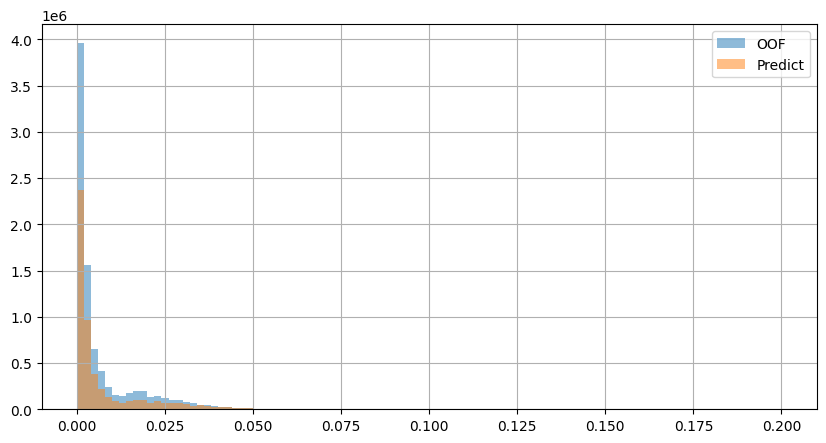

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
bins = np.linspace(0, 0.2, 101)

ax.hist(oof, bins=bins, alpha=.5, label="OOF")
ax.hist(pred_prob, bins=bins, alpha=.5, label="Predict")

ax.legend()
ax.grid()

# 提出

In [ ]:
test_pred_df = create_top_10_yad_predict(predict=pred_prob, session_yad_df=test_session_yad_df)
test_pred_df.iloc[:, :10].fillna(0).astype(int).add_prefix("predict_")\
    .to_csv(os.path.join("../#4_submission.csv"), index=False)